In [1]:
import torch
loaded = torch.load("logs/2022-01-13_14:14:50")


In [3]:
from slot_attention_state_ae import DiscreteSlotAttention_model

net = DiscreteSlotAttention_model(
    n_slots=10,
    n_iters=3,
    n_attr=18,
    in_channels=1,
    encoder_hidden_channels=64,
    attention_hidden_channels=128,
    decoder_hidden_channels=64,
    decoder_initial_size=(7, 7)
)

model = torch.nn.DataParallel(net, [0])
model.load_state_dict(loaded["weights"])



RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.mlp_to_gs.weight", "module.mlp_to_gs.bias", "module.mlp_from_gs.weight", "module.mlp_from_gs.bias". 
	Unexpected key(s) in state_dict: "module.mlp_to_gs.0.weight", "module.mlp_to_gs.0.bias", "module.mlp_to_gs.2.weight", "module.mlp_to_gs.2.bias", "module.mlp_from_gs.0.weight", "module.mlp_from_gs.0.bias". 

torch.Size([2, 84, 84, 3])


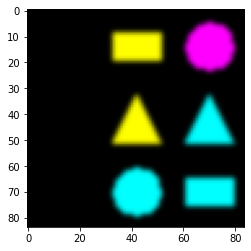

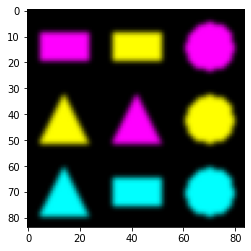

In [2]:
%matplotlib inline
from data import get_loader
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2 as cv
loader = get_loader(total_samples=2, dataset="color_shapes", deletions=5, blur=1)
iter, x = list(enumerate(loader))[0]
# x = x.to(torch.device("cuda"))
x = x.permute((0,2,3,1))
# model.train()
# recon_combined, recons, masks, slots = model.forward(x, 100)

from util import show_mnist_images
print(x.shape)
plt.imshow(x.cpu().detach().numpy()[0])
plt.figure()
plt.imshow(x.cpu().detach().numpy()[1])
# show_mnist_images(recon_combined.cpu().detach().numpy()[0])
# show_mnist_images(recons[0].cpu().detach().numpy()[0])